# Reconocimiento de Patrones
[Curso de Reconocimiento de Patrones]

Departamento Electrónica

Universidad Popular del Cesar

José Ramón Iglesias Gamarra



# Ejemplos: Características de Intensidad (básicas, contraste y CLP)

En este ejemplo se muestra cómo usar las características de intensidad en radiografías de frutas y piezas metálicas. Ejemplos extraídos del libro [Computer Vision for X-ray Testing](https://domingomery.ing.puc.cl/publications/book/) (Mery & Pieringer, Springer, 2021).



# Environment Setup
Download and install in Colab required packages and import libraries.

## PyXvis Library

PyXvis es una librería creada recientemente para el libro [Computer Vision for X-ray Testing](https://domingomery.ing.puc.cl/publications/book/) (Mery & Pieringer, Springer, 2021). En los ejemplos de este notebook, se utiliza esta librería sólo para la extracción de características. Por el momento. como la instalación de PyXvis usando 'pip install pyxvis' es inestable, usaremos esta instalación: 

In [ ]:
!wget https://www.dropbox.com/s/54jfodpv1h4d0kl/pyxvis.zip
!unzip pyxvis.zip
!rm pyxvis.zip
print('PyXvis library downloaded.')

## Images of the Dataset
Downloading of X-ray images of GDXray that are used in these examples. GDXray

In [ ]:
!wget https://www.dropbox.com/s/sv6657lm21iv2aq/images.zip
!unzip images.zip
!rm images.zip

## Installation of Libraries

In [ ]:
!pip install scipy==1.2
!pip3 install pybalu==0.2.5
!pip install ./pyxvis

# Example 1: Características de intensidad básicas

In this example, we show how to extract six basic intensity features of ten apples. The six features are:

* $f_1$: Intensity mean

* $f_2$: Intensity standard deviation 

* $f_3$: Intensity kurtosis 

* $f_4$: Intensity skewness 

* $f_5$: Mean Laplacian

* $f_6$: Mean boundary gradient



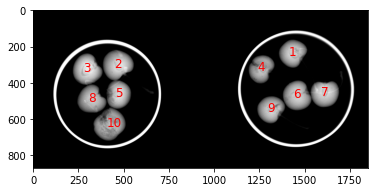

Basic Int-Features:
[[ 5.97390564e-01  1.48199840e-01  2.12642565e+00 -5.08268315e-01
  -1.12537549e-03  3.60309908e-02]
 [ 6.21314523e-01  1.65069755e-01  2.04934173e+00 -3.61325182e-01
  -1.26796994e-03  3.65422341e-02]
 [ 6.60046610e-01  1.74413910e-01  2.22110960e+00 -4.82567213e-01
  -1.17936372e-03  3.97208984e-02]
 [ 5.41639443e-01  1.28334725e-01  2.17818128e+00 -4.04195106e-01
  -1.31330398e-03  3.13098302e-02]
 [ 6.06350114e-01  1.67084076e-01  1.87707870e+00 -3.00941460e-01
  -1.21231089e-03  3.44921519e-02]
 [ 5.99855521e-01  1.49201489e-01  2.09719930e+00 -4.69470013e-01
  -1.12198416e-03  3.55934776e-02]
 [ 6.29405183e-01  1.56278183e-01  2.23710800e+00 -5.71270202e-01
  -1.30564663e-03  4.38084941e-02]
 [ 5.70404639e-01  1.42581478e-01  1.99550043e+00 -3.67717582e-01
  -1.14902548e-03  3.29111699e-02]
 [ 5.89185893e-01  1.47350420e-01  2.05863315e+00 -4.32814809e-01
  -1.25871558e-03  3.54940881e-02]
 [ 5.32133977e-01  1.17461022e-01  2.42283358e+00 -3.96376643e-01
  -1.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label
from pyxvis.features.extraction import extract_features

fig    = plt.figure()
ax     = fig.add_subplot(111)
img    = plt.imread('images/N0001_0004b.png')
implot = plt.imshow(img,cmap='gray')    
R      = img>0.27     # segmentation
L      = label(R)     # labeling
n      = np.max(L)    # number of segmented regions
t      = 0
T      = np.zeros((n,6))
for i in range(n):
    R = (L == i)*1    # binary image of object i
    f = extract_features('basicgeo',bw=R)
    area = f[4]
    # recognition of fruits according to the size
    if area>14000 and area<21000:
        # extract int features only in the segmented region
        h      = extract_features('basicint',img=img,bw=R)
        T[t,:] = h
        t = t+1
        ax.text(f[1]-20, f[0]+10, str(t), fontsize=12,color='Red')
plt.show()
F = T[0:t,:]
print('Basic Int-Features:')
print(F)
np.save('IntFeatures.npy',F) # save features

The basic geometric features are extracted by  function `extract_features` of PyXvis  with parameters `'basicint'`, `img=img`, and `bw=R`, where `img` is the original X-ray image and `R` is the binary image that indicates the pixels where the intensity features are extracted.

# Ejemplo 2: Defect detection using contrast features

In this example, we show how to detect small defects in an X-ray image of a casting image using area and contrast features. We follow the general block-diagram:

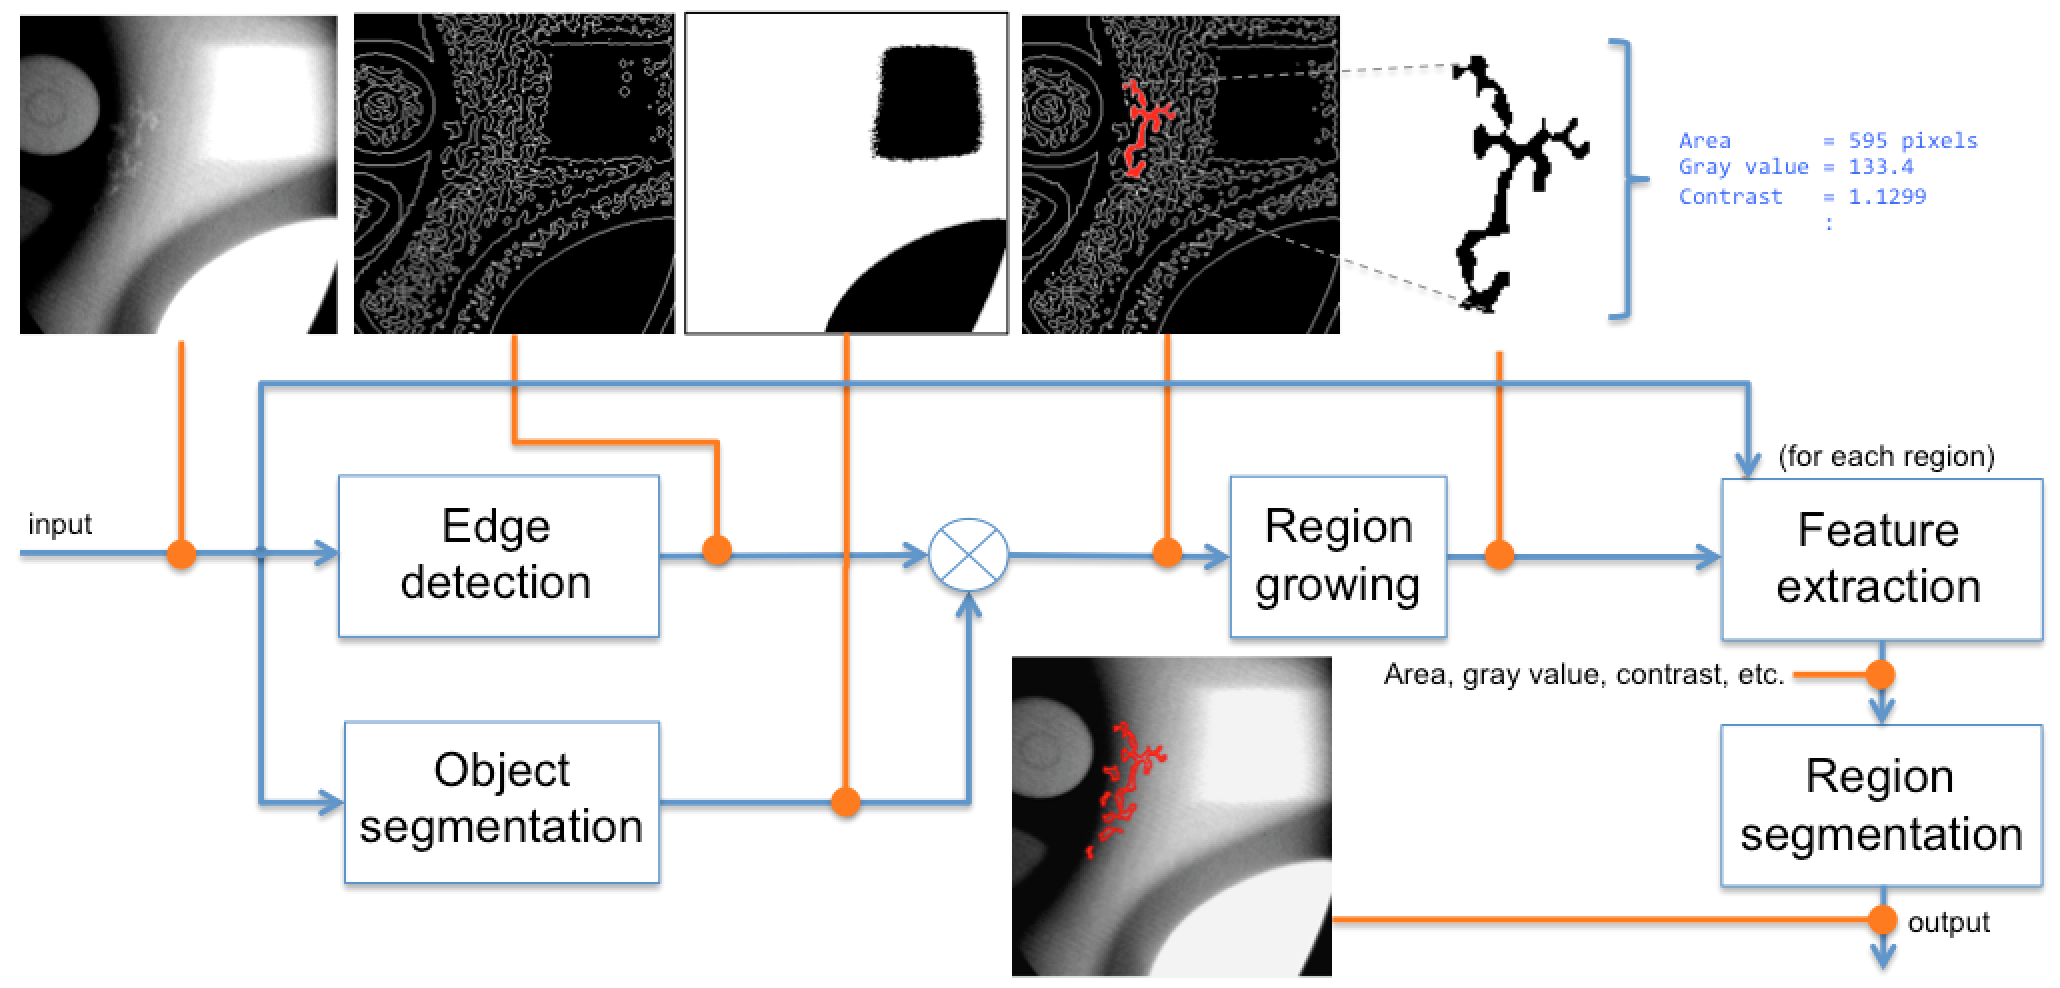

Here, area and contrast features are extracted for each region as defined by enclosed edges. The detection is performed if the size of the region is between some thresholds and the contrast is high enough.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyxvis.processing.images import gradlog
from skimage.measure import label
from pyxvis.features.extraction import extract_features

img    = plt.imread('images/small_wheel.png')  # input image with a defect
(N,M)  = img.shape
e      = gradlog(img,1.25,4/250)
L      = label(~e)         # labeling of objects
n      = np.max(L)         # number of detected objects

K1     = np.zeros((N,M), dtype=bool)
K2     = np.zeros((N,M), dtype=bool)
# Analysis of each segmented object
for i in range(n):
    R = (L == i)                             # binary image of object i
    f = extract_features('basicgeo',bw=R*1)  # feature extraction for object i
    area = f[4]
    # recognition of potential defects according to the size
    if area>20 and area<40:
        K1 = np.bitwise_or(K1,R)
        i0 = int(round(f[0]))
        j0 = int(round(f[1]))
        h  = int(round(f[2]/2))
        w  = int(round(f[3]/2))
        i1 = max(i0-h,0)
        j1 = max(j0-w,0)
        i2 = min(i0+h,N-1)
        j2 = min(j0+w,M-1)
        I  = img[i1:i2,j1:j2]
        bw  = R[i1:i2,j1:j2]
        x  = extract_features('contrast',img=I,bw=bw)
        if x[3]>1.5:
            print('contrast features:')
            print(x)
            print('area = '+str(area)+' pixels')
            K2 = np.bitwise_or(K2,R)

fig, ax = plt.subplots(1, 4, figsize=(16, 8))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')
ax[0].axis('off')
ax[1].imshow(e, cmap='gray')
ax[1].set_title('Edges')
ax[1].axis('off')
ax[2].imshow(K1, cmap='gray')
ax[2].set_title('Potential defects')
ax[2].axis('off')
ax[3].imshow(K2, cmap='gray')
ax[3].set_title('Detected defects')
ax[3].axis('off')
plt.show()



# Ejemplo 3: Crossing line profiles (CLP)
In this example, we show how to detect a very small casting defect that is located at the edge of a regular structure using area and CLP features. We follow the general block-diagram shown in previous example. That is area and contrast features are extracted for each region defined by enclosed edges. The detection is performed in two steps: i) we detect *potential defects*, i.e, regions that are enclosed by edges that have a size between some thresholds, and ii) we select from the potential defects those regions that have a CLP feature high enough. CLP feature is extracted from a window of the image that contains the potential defect in the middle.



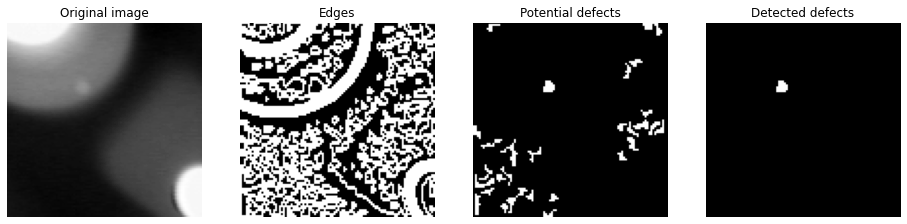

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from pyxvis.processing.images import gradlog
from pyxvis.features.extraction import extract_features

from skimage.measure import label


img    = plt.imread('images/small_wheel.png')  # input image with a defect
(N,M)  = img.shape
e      = gradlog(img,1.25,4/250)
L      = label(~e)         # labeling of objects
n      = np.max(L)         # number of detected objects

K1     = np.zeros((N,M), dtype=bool)
K2     = np.zeros((N,M), dtype=bool)

# Analysis of each segmented object
for i in range(n):
    R = L == i                                # binary image of object i
    f = extract_features('basicgeo', bw=R*1)  # feature extraction for object i
    area = f[4]

    # recognition of potential defects according to the size
    if area > 10 and area < 40:
        K1 = np.bitwise_or(K1,R)
        i0 = int(round(f[0]))
        j0 = int(round(f[1]))
        h  = int(round(f[2]/2))
        w  = int(round(f[3]/2))
        i1 = max(i0-h,0)
        j1 = max(j0-w,0)
        i2 = min(i0+h,N-1)
        j2 = min(j0+w,M-1)
        I  = img[i1:i2,j1:j2]
        x  = extract_features('clp', img=I)
        if x[5]>0.4:
            K2 = np.bitwise_or(K2,R)

fig, ax = plt.subplots(1, 4, figsize=(16, 8))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')
ax[0].axis('off')
ax[1].imshow(e, cmap='gray')
ax[1].set_title('Edges')
ax[1].axis('off')
ax[2].imshow(K1, cmap='gray')
ax[2].set_title('Potential defects')
ax[2].axis('off')
ax[3].imshow(K2, cmap='gray')
ax[3].set_title('Detected defects')
ax[3].axis('off')
plt.show()


In this example, the edges are detected using command `gradlog` of PyXvis, that computes the logical "OR" of edge detection using LoG and edge detection by thresholding the gradient. The contrast features are extracted using command `extract_features` of PyXvis  with parameters `'clp'`, `img=I`, where `I` is an image that contains the potential defects in the middle.  In this example we use features $F_1$ of CLP (see details in Section 5.3.3.